In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import pystan
#from datetime import datetime

pd.set_option("display.max_rows", 101)
pd.set_option("display.max_columns", 101)
%matplotlib inline

In [37]:
#データ読み込み
visit=pd.read_csv('input/air_visit_data.csv',parse_dates=["visit_date"])
store=pd.read_csv('input/air_store_info.csv')
holiday=pd.read_csv("input/date_info.csv",parse_dates=["calendar_date"])
holiday.rename(columns={"calendar_date":"visit_date"},inplace=True)

In [38]:
#ジャンルを居酒屋に限定
store=store[store["air_genre_name"]=="Izakaya"]
visit=visit[visit["air_store_id"].isin(store["air_store_id"])]

In [40]:
#データの結合
df=pd.merge(visit,store,on="air_store_id",how="left")
df=pd.merge(df,holiday,on="visit_date",how="left")
df=df[df["visit_date"]>=datetime.datetime(2016,7,1)] #データの性質が変わるので7/1以降に

In [41]:
#holiday_flgの調整(土日は０に)
df["holiday_flg_rSS"]=df["holiday_flg"].where(~df["day_of_week"].isin(["Saturday","Sunday"]),0)

In [42]:
#air genreを数値化
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df["air_genre_name"].unique())
df["air_genre_name_num"]=le.transform(df["air_genre_name"]) 
df["air_genre_name_num"]+=1

In [43]:
use_cols=['air_store_id', 'visit_date', 'visitors',
       'holiday_flg_rSS', 'air_genre_name_num']

In [44]:
df=df[use_cols]

In [45]:
#時系列特徴
#tmp=df[df["air_store_id"]=="air_ba937bf13d40fb24"]
tmp=df.drop_duplicates(subset=["visit_date"]).sort_values(by="visit_date")
weeks=tmp["visit_date"].dt.weekday
holidays=tmp["holiday_flg_rSS"]

In [47]:
visitors=df.pivot(index='visit_date', columns='air_store_id', values='visitors').reset_index()

In [48]:
#nanの対応
visitors=visitors.fillna(method='ffill')
visitors=visitors.dropna(axis=1)

In [90]:
#多次元
model = """
    data {
        int n; // サンプルサイズ
        int week_day[n]; // 曜日
        int holiday_val[n]; //土日を除いた祝日フラグ
        int store_num; //店舗数
        matrix[n, store_num] y; //観測値
    }
    parameters {
        vector[6] s_raw;
        vector[store_num] r; //店舗毎のランダム効果
        real<lower=0> s_r;  //ランダム効果の標準偏差
        real muZero; // 左端
        vector[n] mu; // 確率的レベル
        real<lower=0> sigmaV; // 観測誤差の大きさ
        real<lower=0> sigmaW; // 過程誤差の大きさ
        real<lower=0> rh; //祝日効果
        
    }
    
    transformed parameters {
      vector[7] s;
      vector[n] week;
      
      s[1:6] = s_raw;
      s[7] = -sum(s_raw);
      for(i in 1:n){
         week[i] = s[week_day[i]+1];
         }
   
    }
    model {
        // 状態方程式
        mu[1] ~ normal(muZero, sqrt(sigmaW));
        for(i in 2:n) {
            mu[i] ~ normal(mu[i-1], sqrt(sigmaW));
        }
        
        // ランダム効果
        r ~ normal(0, s_r);
        
        // 観測方程式
        for(i in 1:n) {
            for(j in 1:store_num){
                y[i,j] ~ lognormal(mu[i] + week[i] + rh * holiday_val[i] + r[j], sqrt(sigmaV));
            }
        }
        
    }
"""
data={'n': visitors.shape[0], 'y': visitors.iloc[:,1:],'week_day':weeks,'holiday_val':holidays,
      'store_num':180}


In [109]:
%time fit = pystan.stan(model_code=model, data=data, iter=10000, chains=3)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8e4d55c6772967a80b37ab7e8aebae00 NOW.


CPU times: user 16.1 s, sys: 6.67 s, total: 22.8 s
Wall time: 2h 17min 26s


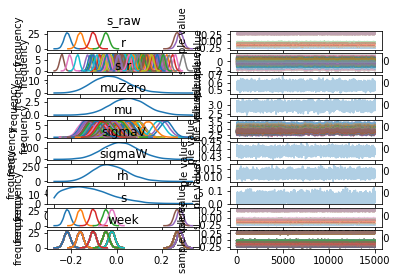

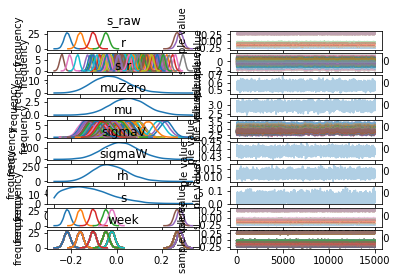

In [110]:
fit.plot()

In [111]:
print(fit)

Inference for Stan model: anon_model_8e4d55c6772967a80b37ab7e8aebae00.
3 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=15000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
s_raw[1]   -0.22  2.7e-4   0.01  -0.25  -0.23  -0.22  -0.21  -0.19   2821    1.0
s_raw[2]   -0.16  2.5e-4   0.01  -0.19  -0.17  -0.16  -0.15  -0.13   3317    1.0
s_raw[3]   -0.05  2.7e-4   0.01  -0.08  -0.06  -0.05  -0.04  -0.02   2848    1.0
s_raw[4]    -0.1  2.7e-4   0.01  -0.13  -0.11   -0.1  -0.09  -0.08   2681    1.0
s_raw[5]    0.28  2.6e-4   0.01   0.25   0.27   0.28   0.29   0.31   2957    1.0
s_raw[6]    0.27  2.6e-4   0.01   0.24   0.26   0.27   0.28    0.3   2950    1.0
r[1]       -0.76  3.8e-3   0.05  -0.87   -0.8  -0.76  -0.72  -0.66    208   1.01
r[2]        0.59  3.9e-3   0.05   0.48   0.56   0.59   0.63    0.7    197   1.01
r[3]        0.64  3.8e-3   0.05   0.53    0.6   0.64   0.67   0.74    211   1.01

In [112]:
import pickle
# 保存
with open('result_190127.pickle', 'wb') as f:
    pickle.dump(fit, f)

/Users/rmizuta/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  """


In [94]:
# サンプル列を抽出
la  = fit.extract(permuted=True)

[]

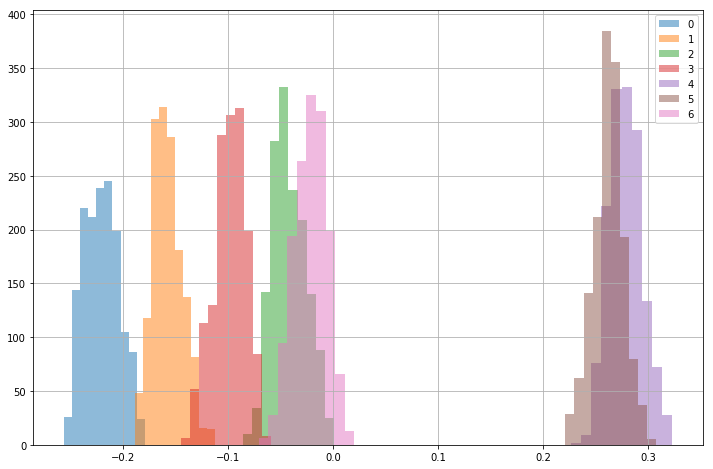

In [122]:
#曜日特性の確認
plt.figure(figsize=(12,8))
for i in range(la["s"].shape[1]):
    pd.Series(la["s"][:,i]).hist(label=i, alpha=0.5)
plt.legend()
plt.plot()

[]

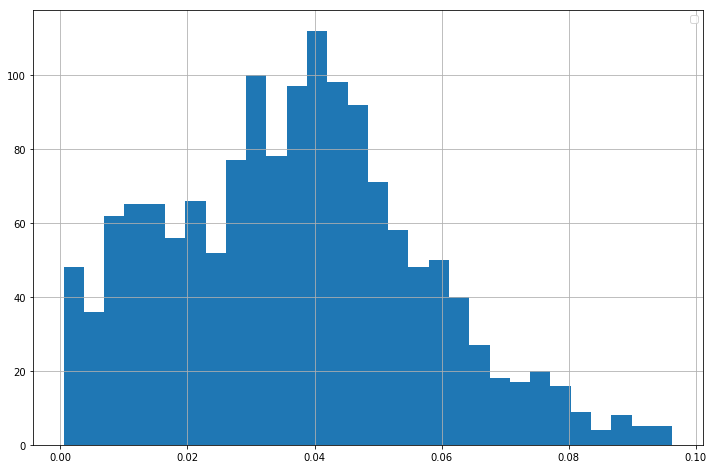

In [127]:
#祝日効果の確認
plt.figure(figsize=(12,8))
#for i in range(la["s"].shape[1]):
pd.Series(la["rh"]).hist(bins=30)
plt.legend()
plt.plot()

In [181]:
#例1
pred=[]
for i in range(visitors.shape[0]):
    pred.append(np.exp(la["mu"][:,i].mean(axis=0)+la["week"][:,i].mean(axis=0)+la["rh"].mean()*holidays.values[i]+la["r"][:,0].mean()))

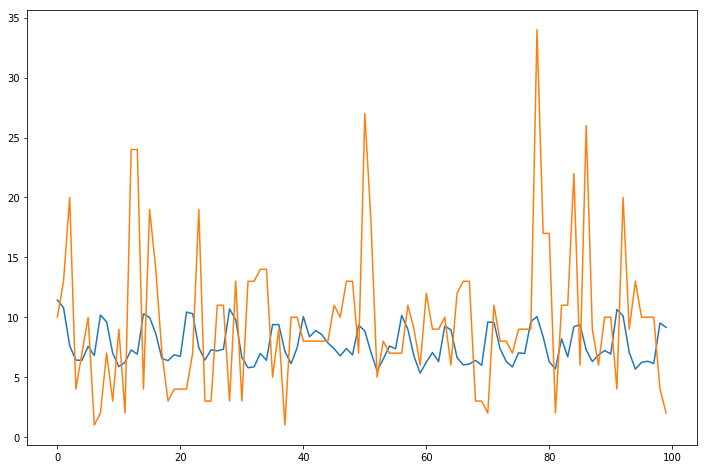

In [182]:
plt.figure(figsize=(12,8))
plt.plot(pred[:100])
plt.plot(visitors["air_0241aa3964b7f861"][:100])

In [167]:
#例2
pred=[]
for i in range(visitors.shape[0]):
    pred.append(np.exp(la["mu"][:,i].mean(axis=0)+la["week"][:,i].mean(axis=0)+la["rh"].mean()*holidays.values[i]+la["r"][:,1].mean()))

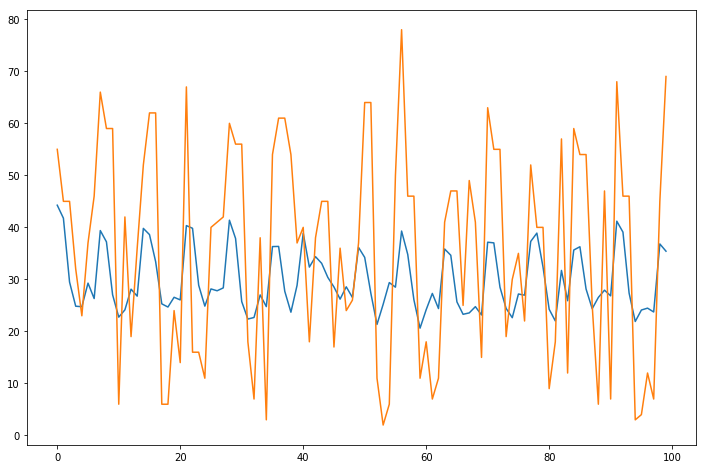

In [180]:
plt.figure(figsize=(12,8))
plt.plot(pred[:100])
plt.plot(visitors["air_03963426c9312048"][:100])